In [3]:
import numpy as np
import torch as t # torch も必要なのでインポートを保持
import matplotlib.pyplot as plt

# pa_generator から DataLoaderAug と helper function をインポート
# pa_generator.data_augmentation が実際のファイルパスと仮定
from pa_generator.data_augmentation import DataLoaderAug, ANOMALY_TYPE_DEFAULTS, COMMON_ANOMALY_PARAMS
from pa_generator.data_augmentation import AnomalyInjector # generate_anomaly_types_from_one_hot のために必要

# --- ダミーデータの作成 ---
# 特徴量2つ、時間ステップ1000のランダムな時系列データ
dataset = np.random.randn(2, 1000)

print("Loading augmentation modules...")

# --- DataLoaderAug のインスタンス化とデータ生成 ---
# スパイク、ノイズ、通常のデータ、そしてランダムな異常を生成
# カスタムパラメータでスパイクのスケールとノイズのスケールを変更
loader = DataLoaderAug(
    dataset=dataset,
    anomaly_types=['normal', 'spike', 'noise', 'random'], # randomを指定するとランダムな異常が選ばれます
    params={
        'spike': {'scale': 1, 'min_features': 2, 'max_features': 2},
        'noise': {'scale': 0.5},
        'average': {'ma_window': 10}, # average のテスト用パラメータ
        # 'random' に固有のパラメータが必要な場合はここに記述
    },
    window_size=100,
    window_step=50,
    minmax=True,
)

# --- 生成されたデータへのアクセス ---
y_anomalous = loader.Y_windows      # 異常注入後のウィンドウデータ
z_normal = loader.Z_windows         # 異常注入前の元のウィンドウデータ
anomaly_mask = loader.anomaly_mask  # 異常箇所を示すマスク (0が異常)
labels_one_hot = loader.label       # 各ウィンドウの異常タイプのOne-Hotラベル

print(f"\n--- 生成結果の概要 ---")
print(f"生成されたウィンドウの総数: {y_anomalous.shape[0]}")
print(f"Y_anomalousの形状: {y_anomalous.shape}") # [B, D, W]
print(f"Z_normalの形状: {z_normal.shape}")       # [B, D, W]
print(f"anomaly_maskの形状: {anomaly_mask.shape}") # [B, D, W]
print(f"labels_one_hotの形状: {labels_one_hot.shape}") # [B, N_anomaly_types]

# --- ラベルの変換と表示 ---
# AnomalyInjectorの静的メソッドを使ってOne-Hotを元の異常タイプ名に変換
# DataLoaderAugはAnomalyInjectorを継承しているので、直接メソッドを呼び出せる
first_5_labels_str = loader.generate_anomaly_types(labels_one_hot[:5], loader.anomaly_dict)
print(f"最初の5つの異常タイプラベル: {first_5_labels_str}")

print(f"\n--- 各異常タイプのサンプル数 ---")
# 全てのラベルを文字列に変換
all_labels_str = loader.generate_anomaly_types(labels_one_hot, loader.anomaly_dict)
from collections import Counter
label_counts = Counter(all_labels_str)
for label, count in label_counts.items():
    print(f"  '{label}': {count} 個")



Loading augmentation modules...

--- 生成結果の概要 ---
生成されたウィンドウの総数: 76
Y_anomalousの形状: torch.Size([76, 2, 100])
Z_normalの形状: torch.Size([76, 2, 100])
anomaly_maskの形状: torch.Size([76, 2, 100])
labels_one_hotの形状: torch.Size([76, 13])
最初の5つの異常タイプラベル: ['normal', 'normal', 'normal', 'normal', 'normal']

--- 各異常タイプのサンプル数 ---
  'normal': 19 個
  'spike': 20 個
  'noise': 19 個
  'speedup': 2 個
  'contextual': 4 個
  'cutoff': 3 個
  'flip': 1 個
  'mixture': 4 個
  'upsidedown': 2 個
  'average': 1 個
  'wander': 1 個



--- 異常注入結果の可視化 ---


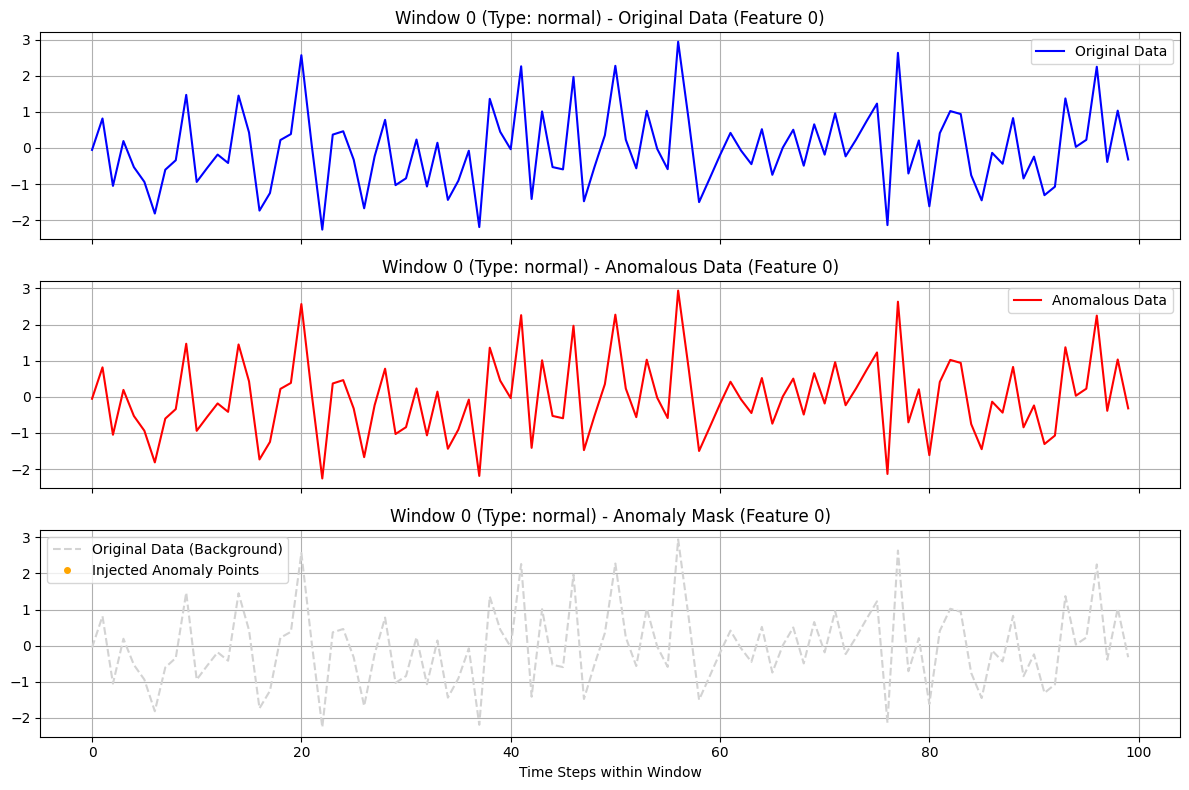

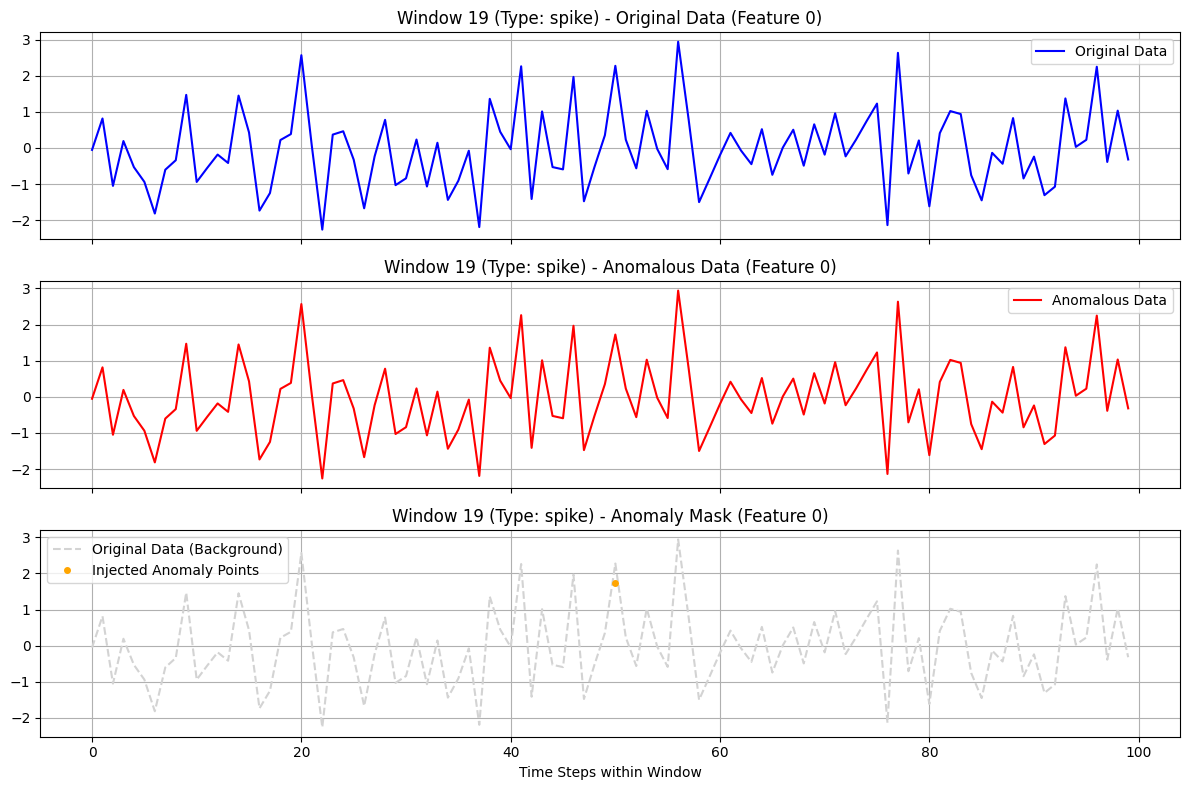

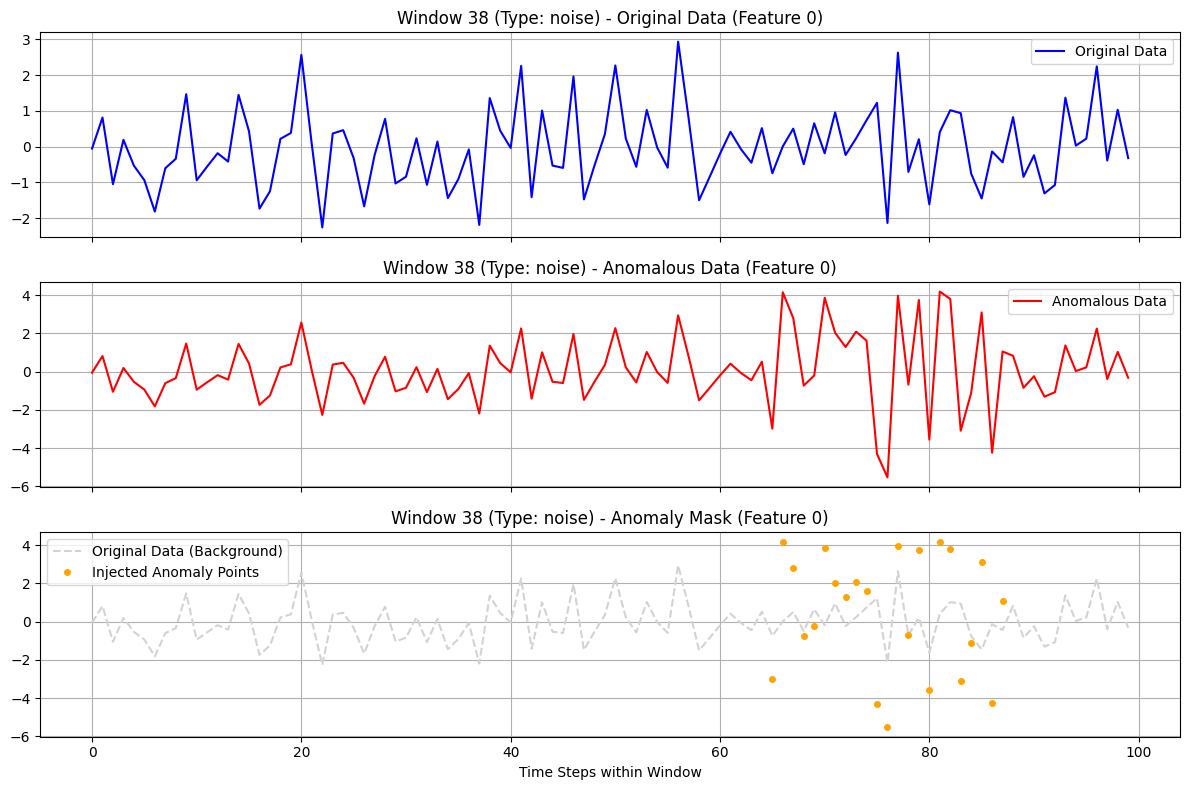

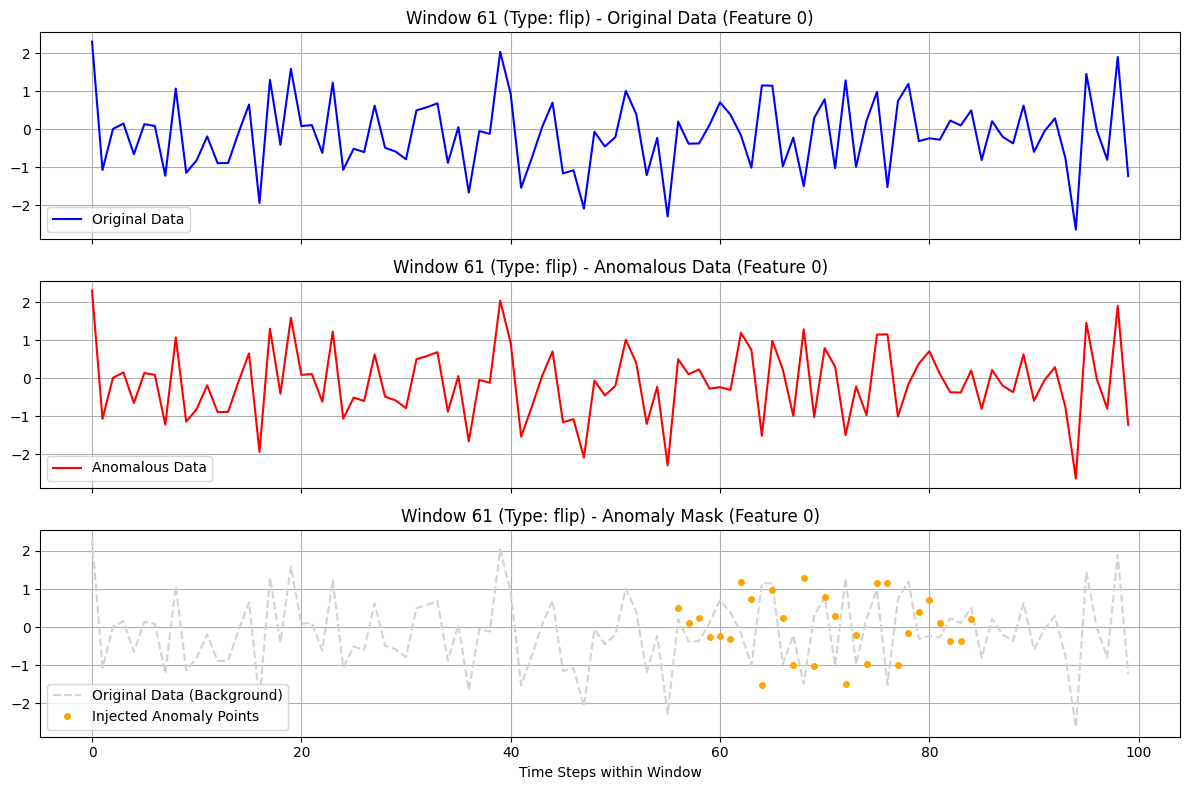

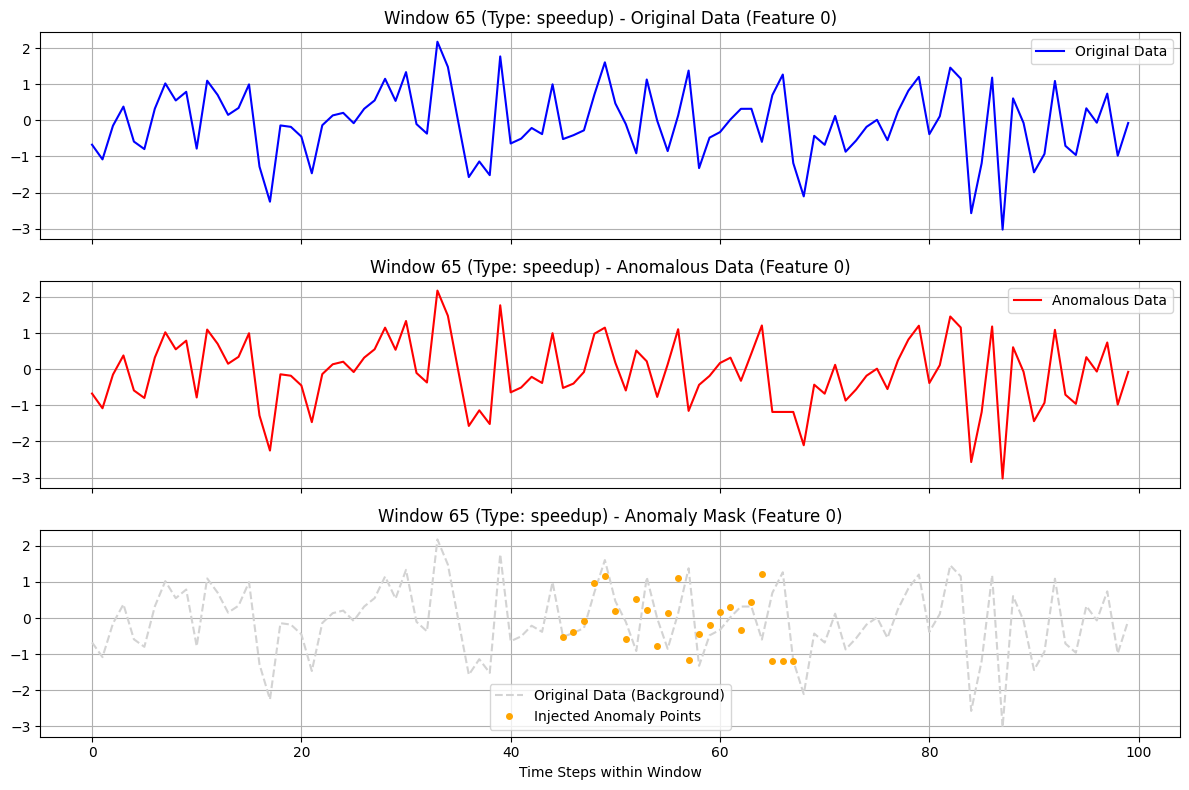

In [4]:
## Visualization

# 次に、生成されたデータの中からいくつかのウィンドウを選び、元のデータ、異常注入後のデータ、そして異常マスクを可視化します。これにより、異常がどのように注入されたかを視覚的に確認できます。

# --- 可視化関数 ---
def plot_anomaly_injection(
    original_data: t.Tensor,
    anomalous_data: t.Tensor,
    anomaly_mask: t.Tensor,
    anomaly_type: str,
    window_idx: int,
    feature_idx: int = 0
):
    """
    異常注入の前後を可視化する。

    Parameters
    ----------
    original_data : torch.Tensor
        元のウィンドウデータ (Z_windows)。
    anomalous_data : torch.Tensor
        異常注入後のウィンドウデータ (Y_windows)。
    anomaly_mask : torch.Tensor
        異常マスク (0が異常)。
    anomaly_type : str
        このウィンドウの異常タイプ名。
    window_idx : int
        表示するウィンドウのインデックス。
    feature_idx : int, optional
        表示する特徴量のインデックス。デフォルトは0。
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    time_points = np.arange(original_data.shape[2]) # ウィンドウの長さ

    # 元のデータ
    axes[0].plot(time_points, original_data[window_idx, feature_idx].cpu().numpy(), label='Original Data', color='blue')
    axes[0].set_title(f'Window {window_idx} (Type: {anomaly_type}) - Original Data (Feature {feature_idx})')
    axes[0].legend()
    axes[0].grid(True)

    # 異常注入後のデータ
    axes[1].plot(time_points, anomalous_data[window_idx, feature_idx].cpu().numpy(), label='Anomalous Data', color='red')
    axes[1].set_title(f'Window {window_idx} (Type: {anomaly_type}) - Anomalous Data (Feature {feature_idx})')
    axes[1].legend()
    axes[1].grid(True)

    # 異常マスク
    # マスクは0が異常なので、1-maskで異常箇所を強調
    anomaly_locations = (anomaly_mask[window_idx, feature_idx].cpu().numpy() == 0)

    axes[2].plot(time_points, original_data[window_idx, feature_idx].cpu().numpy(), color='lightgray', linestyle='--', label='Original Data (Background)') # 背景に元のデータ
    axes[2].plot(time_points[anomaly_locations], anomalous_data[window_idx, feature_idx, anomaly_locations].cpu().numpy(),
                 'o', markersize=4, color='orange', label='Injected Anomaly Points')
    axes[2].set_title(f'Window {window_idx} (Type: {anomaly_type}) - Anomaly Mask (Feature {feature_idx})')
    axes[2].set_xlabel('Time Steps within Window')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

# --- 可視化の実行 ---
print(f"\n--- 異常注入結果の可視化 ---")

# いくつかのランダムなウィンドウを選んで可視化
num_plots = 5 # 可視化するウィンドウの数
num_total_windows = y_anomalous.shape[0]

# 可能な場合は、特定の異常タイプを持つウィンドウを選択して可視化する
# たとえば、'spike' や 'noise' のサンプルを探す
sample_indices_to_plot = []
plotted_types = set()

# 'normal', 'spike', 'noise', 'flip', 'speedup', 'average', 'scale', 'wander', 'contextual', 'upsidedown', 'mixture' を順番に試す
desired_plot_types = ['normal', 'spike', 'noise', 'flip', 'speedup', 'average', 'scale', 'wander', 'contextual', 'upsidedown', 'mixture']
type_idx = 0

for i in range(num_total_windows):
    current_type = loader.generate_anomaly_types(labels_one_hot[i:i+1], loader.anomaly_dict)[0]

    if current_type == desired_plot_types[type_idx] and current_type not in plotted_types:
        sample_indices_to_plot.append(i)
        plotted_types.add(current_type)
        type_idx += 1
        if type_idx >= len(desired_plot_types) or len(sample_indices_to_plot) >= num_plots:
            break

# もし特定のタイプが見つからなければ、単純に最初のいくつかを表示
if len(sample_indices_to_plot) < num_plots:
    remaining_plots = num_plots - len(sample_indices_to_plot)
    for i in range(num_total_windows):
        if i not in sample_indices_to_plot and remaining_plots > 0:
            sample_indices_to_plot.append(i)
            remaining_plots -= 1
        if remaining_plots == 0:
            break

for idx in sample_indices_to_plot:
    current_anomaly_type = loader.generate_anomaly_types(labels_one_hot[idx:idx+1], loader.anomaly_dict)[0]
    # 複数の特徴量がある場合、ランダムに特徴量を選ぶか、全ての特徴量を可視化するか選択できます
    # ここでは便宜上、0番目の特徴量を可視化します
    plot_anomaly_injection(z_normal, y_anomalous, anomaly_mask, current_anomaly_type, idx, feature_idx=0)